In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import time
import matplotlib.pyplot as plt

import sys
import os

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


measure_sampling_path = os.path.abspath(
    "/Users/rubenbontorno/Documents/Master_Thesis/Code/AWD_numerics/Measure_sampling"
)
CD_path = os.path.abspath(
    "/Users/rubenbontorno/Documents/Master_Thesis/Code/AWD_numerics/Conditional_density"
)

if measure_sampling_path not in sys.path:
    sys.path.append(measure_sampling_path)

if CD_path not in sys.path:
    sys.path.append(CD_path)

from Gen_Path_and_AdaptedTrees import *

from CD_knn_NerualNet import *

from IPython.display import display, clear_output

## Set up

In [5]:
# Generate Brownian motion paths
n_data = 3000
time_steps = 3  # For example, t=0, t=1, t=2
paths = generate_brownian_motion(num_paths=n_data, time_steps=time_steps, scale=1)

X = np.expand_dims(paths[:, 1], axis=1)
Y = np.expand_dims(paths[:, 2], axis=1)
d_X = 1
d_Y = 1


data = np.concatenate([X, Y], axis=1)

data_tensor = torch.tensor(data, dtype=torch.float32).to(device)


min_path = np.round(100 * np.min(paths[:, 1])) / 100
max_path = np.round(100 * np.max(paths[:, 1])) / 100

# Define multiple x_0 values
x0_values = [0, 1, -2, 0.5, min_path, max_path]

k_values = list(range(2, 11))  # Converts range to list
k_values.extend([20, 30, 40, 50])  # Adds additional values

## for non Lip

Training took 16.75 seconds.
Number of NaN losses encountered: 28
Trained estimator for k = 2. Number of NaN losses encountered: 28
Training took 16.40 seconds.
Number of NaN losses encountered: 2
Trained estimator for k = 3. Number of NaN losses encountered: 2
Training took 17.96 seconds.
Number of NaN losses encountered: 1
Trained estimator for k = 4. Number of NaN losses encountered: 1
Training took 19.58 seconds.
Number of NaN losses encountered: 0
Trained estimator for k = 5. Number of NaN losses encountered: 0
Training took 21.17 seconds.
Number of NaN losses encountered: 0
Trained estimator for k = 6. Number of NaN losses encountered: 0
Training took 24.76 seconds.
Number of NaN losses encountered: 0
Trained estimator for k = 7. Number of NaN losses encountered: 0
Training took 29.34 seconds.
Number of NaN losses encountered: 0
Trained estimator for k = 8. Number of NaN losses encountered: 0
Training took 31.29 seconds.
Number of NaN losses encountered: 0
Trained estimator for k

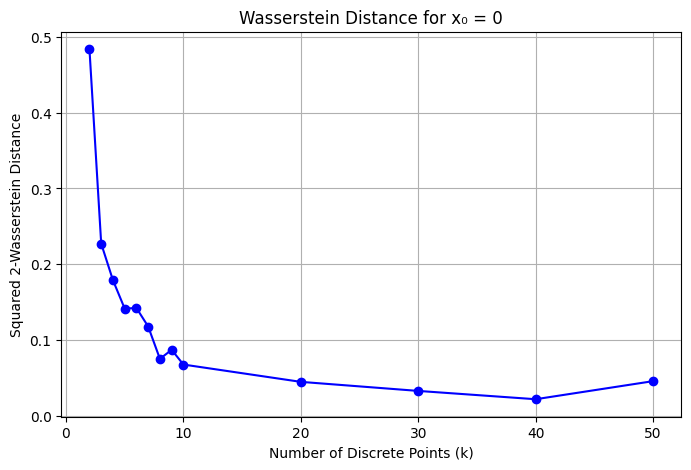

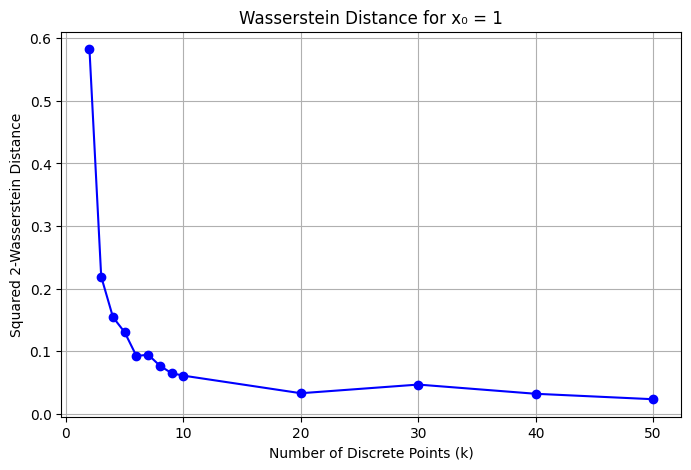

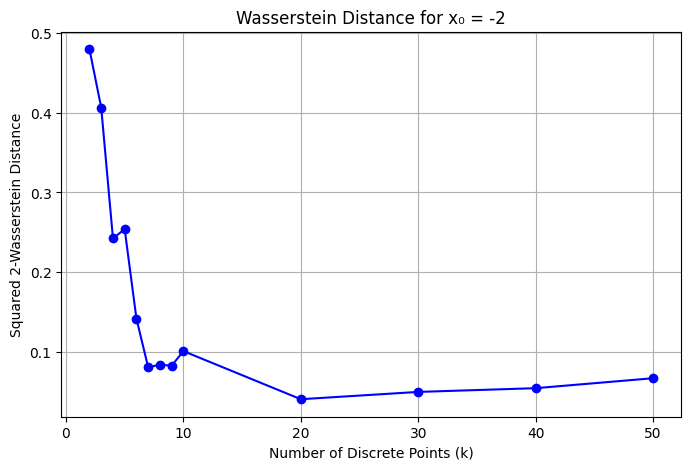

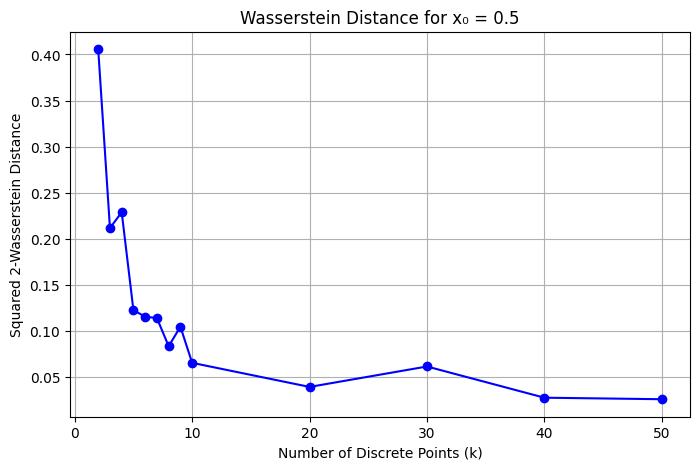

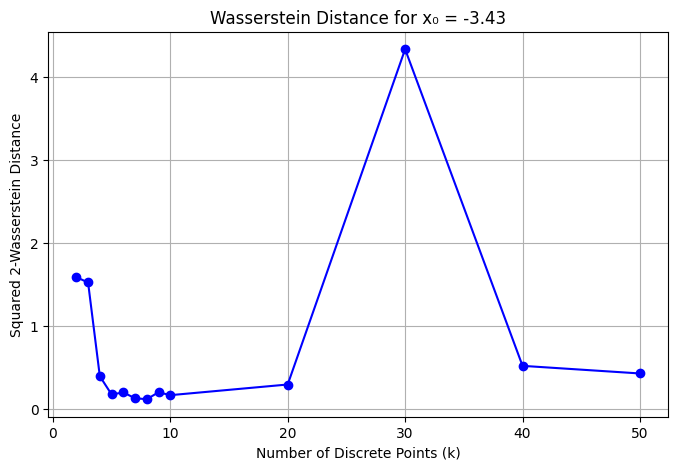

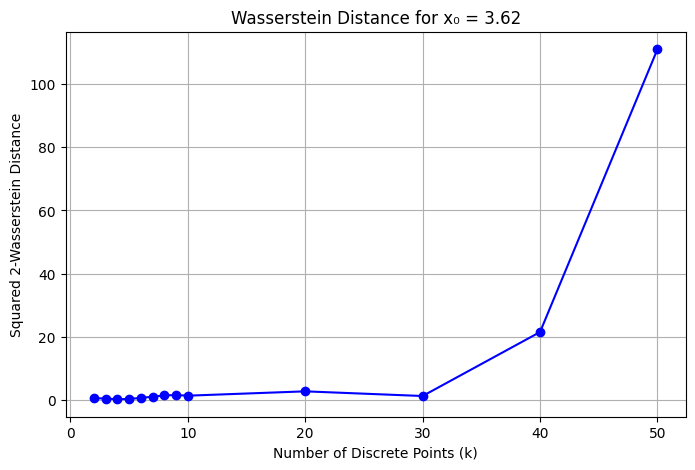

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import ot


def compute_w2_squared(discrete_support, discrete_weights, true_support, true_weights):
    """
    Compute squared 2-Wasserstein distance between two discrete measures.
    discrete_support: 1D numpy array of support points (length m)
    discrete_weights: 1D numpy array of weights (length m, summing to 1)
    true_support: 1D numpy array of support points for the true measure (length n)
    true_weights: 1D numpy array of weights for the true measure (length n, summing to 1)
    """
    # Compute the squared Euclidean cost matrix between the supports.
    M = (discrete_support[:, None] - true_support[None, :]) ** 2
    # ot.emd2 returns the squared Wasserstein distance
    return ot.emd2(discrete_weights, true_weights, M)


results = {x0: {} for x0 in x0_values}  # will store distances for each x0 and k

# device should be defined (e.g., device = torch.device('cuda') or 'cpu')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Main Loop over k ---
for k in k_values:
    # Train the conditional density estimator for the current k.
    estimator, loss_hist, n_nan = train_conditional_density(
        data_tensor,
        d_X=d_X,
        d_Y=d_Y,
        k=k,
        n_iter=1500,
        n_batch=100,
        lr=1e-3,
        nns_type=" ",
    )

    estimator.atomnet.to(device)
    estimator.atomnet.eval()
    print(f"Trained estimator for k = {k}. Number of NaN losses encountered: {n_nan}")

    # For each x0 value, evaluate the estimator and compute the Wasserstein distance.
    for x0 in x0_values:
        # Evaluate the estimator at x0 (make sure to use a torch tensor of shape [1,1])
        with torch.no_grad():
            x0_tensor = torch.tensor([[x0]], dtype=torch.float32, device=device)
            y_est = estimator.atomnet(x0_tensor)  # assume output shape is [1, k]

        # Convert the output to a 1D numpy array
        y_est_np = y_est.cpu().numpy().flatten()

        # Define the estimated measure: k points with uniform weight 1/k.
        weights_est = np.ones(k) / k

        # Create a grid for the true measure. We choose a grid centered at x0.
        y_min = x0 - 5
        y_max = x0 + 5
        y_grid = np.linspace(y_min, y_max, 800)
        dx = y_grid[1] - y_grid[0]

        # Construct the true measure as the discretization of N(x0, 1)
        true_pdf = norm.pdf(y_grid, loc=x0, scale=1)
        true_weights = true_pdf * dx
        true_weights = true_weights / np.sum(true_weights)

        # Compute the squared Wasserstein distance.
        distance = compute_w2_squared(y_est_np, weights_est, y_grid, true_weights)

        # Store the result
        results[x0][k] = distance

# --- Plotting: one plot per x0 ---
for x0 in x0_values:
    ks = sorted(results[x0].keys())
    distances = [results[x0][k] for k in ks]

    plt.figure(figsize=(8, 5))
    plt.plot(ks, distances, marker="o", linestyle="-", color="blue")
    plt.xlabel("Number of Discrete Points (k)")
    plt.ylabel("Squared 2-Wasserstein Distance")
    plt.title(f"Wasserstein Distance for x₀ = {x0}")
    plt.grid(True)
    plt.show()

44
Training took 14.37 seconds.
Number of NaN losses encountered: 4
Trained estimator for k = 2. Number of NaN losses encountered: 4
44
Training took 15.06 seconds.
Number of NaN losses encountered: 0
Trained estimator for k = 3. Number of NaN losses encountered: 0
44
Training took 16.35 seconds.
Number of NaN losses encountered: 0
Trained estimator for k = 4. Number of NaN losses encountered: 0
44
Training took 17.50 seconds.
Number of NaN losses encountered: 0
Trained estimator for k = 5. Number of NaN losses encountered: 0
44
Training took 18.63 seconds.
Number of NaN losses encountered: 0
Trained estimator for k = 6. Number of NaN losses encountered: 0
44
Training took 22.08 seconds.
Number of NaN losses encountered: 0
Trained estimator for k = 7. Number of NaN losses encountered: 0
44
Training took 23.02 seconds.
Number of NaN losses encountered: 0
Trained estimator for k = 8. Number of NaN losses encountered: 0
44
Training took 22.39 seconds.
Number of NaN losses encountered: 0
T

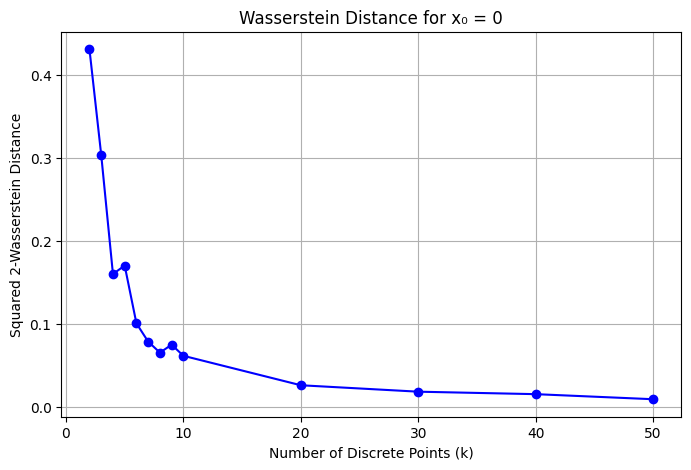

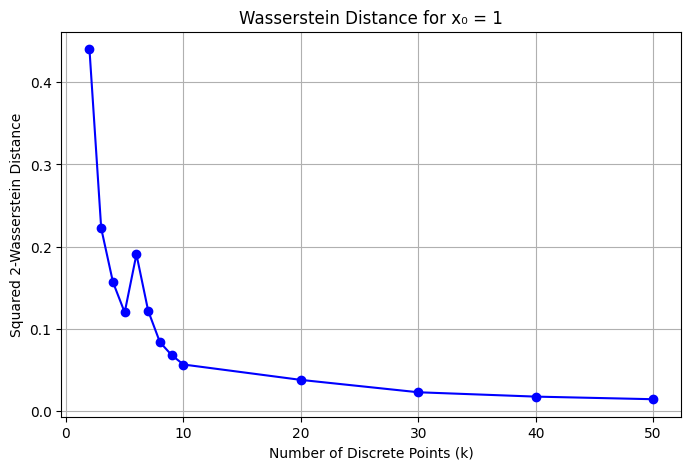

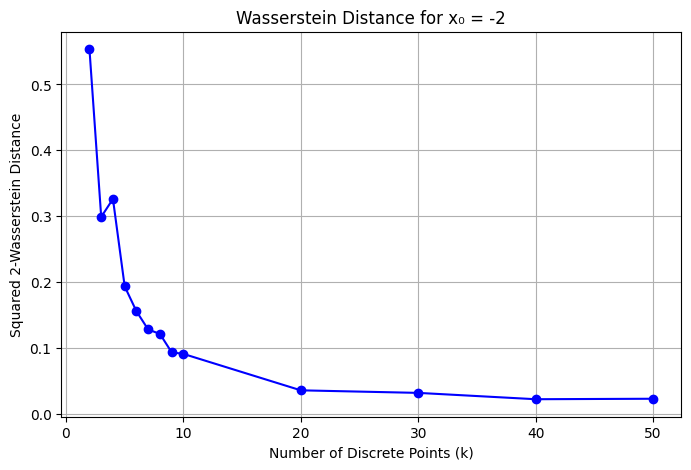

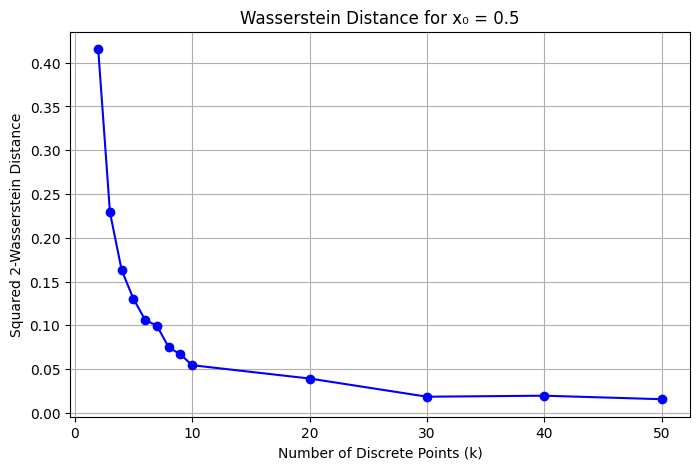

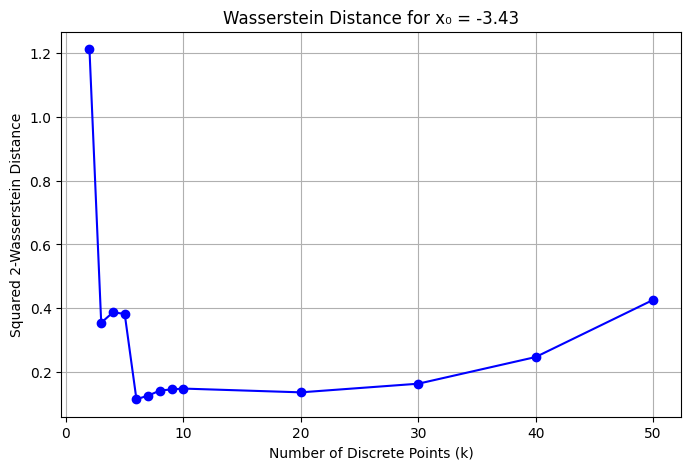

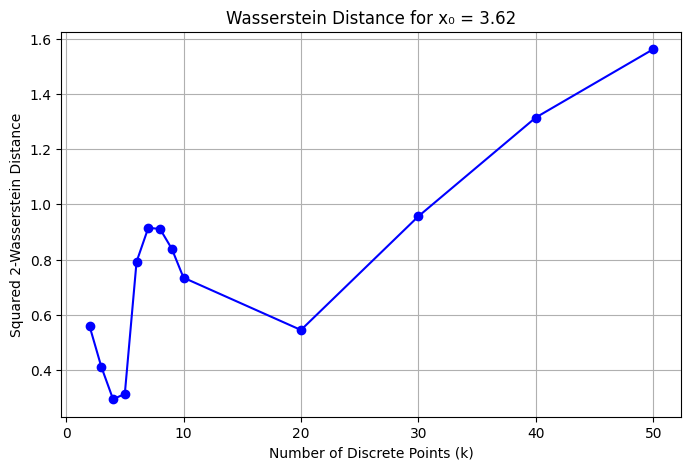

In [7]:
results = {x0: {} for x0 in x0_values}  # will store distances for each x0 and k

# device should be defined (e.g., device = torch.device('cuda') or 'cpu')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# data_tensor, d_X, d_Y, and other hyperparameters are assumed to be defined elsewhere
# For example:
# data_tensor = ...  (your training data as a torch tensor)
# d_X = ... ; d_Y = ...
# Also, the function train_conditional_density is assumed to be defined.
# n_iter, n_batch, lr, and nns_type are set as desired.

# --- Main Loop over k ---
for k in k_values:
    # Train the conditional density estimator for the current k.
    estimator, loss_hist, n_nan = train_conditional_density(
        data_tensor,
        d_X=d_X,
        d_Y=d_Y,
        k=k,
        n_iter=1500,
        n_batch=100,
        lr=1e-3,
        nns_type=" ",
        Lip=True,
    )

    estimator.atomnet.to(device)
    estimator.atomnet.eval()
    print(f"Trained estimator for k = {k}. Number of NaN losses encountered: {n_nan}")

    # For each x0 value, evaluate the estimator and compute the Wasserstein distance.
    for x0 in x0_values:
        # Evaluate the estimator at x0 (make sure to use a torch tensor of shape [1,1])
        with torch.no_grad():
            x0_tensor = torch.tensor([[x0]], dtype=torch.float32, device=device)
            y_est = estimator.atomnet(x0_tensor)  # assume output shape is [1, k]

        # Convert the output to a 1D numpy array
        y_est_np = y_est.cpu().numpy().flatten()

        # Define the estimated measure: k points with uniform weight 1/k.
        weights_est = np.ones(k) / k

        # Create a grid for the true measure. We choose a grid centered at x0.
        y_min = x0 - 5
        y_max = x0 + 5
        y_grid = np.linspace(y_min, y_max, 800)
        dx = y_grid[1] - y_grid[0]

        # Construct the true measure as the discretization of N(x0, 1)
        true_pdf = norm.pdf(y_grid, loc=x0, scale=1)
        true_weights = true_pdf * dx
        true_weights = true_weights / np.sum(true_weights)

        # Compute the squared Wasserstein distance.
        distance = compute_w2_squared(y_est_np, weights_est, y_grid, true_weights)

        # Store the result
        results[x0][k] = distance

# --- Plotting: one plot per x0 ---
for x0 in x0_values:
    ks = sorted(results[x0].keys())
    distances = [results[x0][k] for k in ks]

    plt.figure(figsize=(8, 5))
    plt.plot(ks, distances, marker="o", linestyle="-", color="blue")
    plt.xlabel("Number of Discrete Points (k)")
    plt.ylabel("Squared 2-Wasserstein Distance")
    plt.title(f"Wasserstein Distance for x₀ = {x0}")
    plt.grid(True)
    plt.show()